## Two Story Steel MRF
#### December 2021, By Amir Hossein Namadchi
In this notebook, a 2 story steel moment resisting frame is modeled. This is an OpenSeesPy simulation of TCL version of the model, presented by [*Fernando Gutiérrez Urzúa*](https://www.ucl.ac.uk/epicentre/fernando-gutierrez-urzua) in his [YouTube channel](https://www.youtube.com/user/lfgurzua). Some minor modifications are made by me in the python version. According to his, modeling assumptions are:

- Columns are modeled as distributed plasticity elements
- Beams are modeled as concentrated plasticity elements
- Plastic hinges are modeled as two nodes at the same coordinates, connected via a rotational spring.

The functions defined in this notebook are as follows:
- `W_section`: *Creates W-Section based on nominal dimension and generates fibers over it*
- `build_model`: *Builds the 2D Steel Moment resisting Frame Model*
- `run_gravity`: *Runs gravity analysis*
- `run_modal`: *Runs Modal analysis*
- `run_pushover`: *Runs Pushover analysis*
- `run_time_history`: *Runs Time history analysis*
- `reset_analysis`: *Resets the analysis by setting time to 0,removing the recorders and wiping the analysis.*
 
Please note that some functions use data obtained by running other functions. For example, in order to run Pushover analysis, some components of eigenvectors are needed that is obtained via `run_modal` function.
It's highly recommended to watch Dr. Fernando Gutiérrez Urzúa videos for better understanding.

![Steel Frame](FGU_2SSMRF_files\FGU_2SSMRF.PNG)

### Dependencies

In [1]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

### Functions
Below functions can be encapsulated in a single *.py* file.

In [2]:
def W_section(section, sec_tag, mat_tag, nf_dw, nf_tw, nf_bf, nf_tf):
    
    """
    Creates W-Section based on nominal dimension and generates
    fibers over it
    
    Keyword arguments:
    section -- a dict type containing section info
    sec_tag -- Section tag
    mat_tag -- Material Tag
    nf_dw -- Number of fibers along web depth 
    nf_tw -- Number of fibers along web thickness
    nf_bf -- Number of fibers along flange width
    nf_tf -- Number of fibers along flange thickness    
    """
    # unpack variables for readability
    d, bf = section['d'], section['bf']
    tf, tw = section['tf'], section['tw']
    
    dw = d - 2*tf
    y1, y2, y3, y4 = -d/2, -dw/2, dw/2, d/2
    z1, z2, z3, z4 = -bf/2, -tw/2, tw/2, bf/2
    
    ops.section('Fiber', sec_tag)
    ops.patch('quad', mat_tag, nf_bf, nf_tf,
          *[y1,z4], *[y1,z1], *[y2,z1], *[y2,z4])
    ops.patch('quad', mat_tag, nf_tw, nf_dw,
          *[y2,z3], *[y2,z2], *[y3,z2], *[y3,z3])    
    ops.patch('quad', mat_tag, nf_bf, nf_tf,
          *[y3,z4], *[y3,z1], *[y4,z1], *[y4,z4])          
    
    
def build_model():
    
        
    """
    Builds the 2D Steel Moment resisting Frame Model
    
  
    """
    
    ## Units
    m = 1.0               # Meters
    KN = 1.0              # KiloNewtons
    sec = 1.0             # Seconds

    mm = 0.001*m          # Milimeters
    cm = 0.01*m           # Centimeters
    ton = KN*(sec**2)/m    # mass unit (derived)
    g = 9.81*(m/sec**2)   # gravitational constant 
    

    ops.wipe()
    ops.model('basic','-ndm',2,'-ndf',3)

    L_x = 6.0*m    # Span
    L_y = 3.5*m    # Story Height

    # Node Coordinates Matrix (size : nn x 2)
    node_coords = np.array([[0, 0], [L_x, 0],
                           [0, L_y], [L_x, L_y],
                           [0, 2*L_y], [L_x, 2*L_y],
                           [0, L_y], [L_x, L_y],
                           [0, 2*L_y], [L_x, 2*L_y]])

    # Element Connectivity Matrix (size: nel x 2)
    connectivity = [[1,3], [2,4],
                    [3,5], [4,6],
                    [7,8], [9,10],
                    [7,3], [8,4],
                    [9,5], [10,6]
                   ]

    # Get Number of elements
    nel = len(connectivity)

    # Distinguish beams, columns & hinges by their element tag ID
    all_the_beams = [5, 6]
    all_the_cols = [1, 2, 3, 4]
    all_the_hinges = [7, 8, 9, 10]  

    # Columns are modeled using `Steel01` material, beams are 
    # assumed elastic and plastic hinges are modeled via `Bilin`
    # material, proposed by *D. G. Lignos & H. Krawinkler*
    # Uniaxial bilinear steel material with kinematic hardening
    mat_S355 = {'ID':'Steel01',
                'matTag':1,
                'Fy':(3.55e5)*(KN/m**2),
                'E0':(2.1e8)*(KN/m**2),
                'b':0.01}

    ## Material used for plastic hinges
    # Modified Ibarra-Medina-Krawinkler Deterioration Model with Bilinear Hysteretic Response (Bilin Material)
    # https://ascelibrary.org/doi/full/10.1061/%28ASCE%29ST.1943-541X.0000376
    mat_lignos = {'ID':'Bilin',
                 'matTag':2,
                 'K0':(64033.2)*(KN/m),
                 'as_Plus':0.00203545752454409,
                 'as_Neg':0.00203545752454409,
                 'My_Plus':101.175*(KN*m),
                 'My_Neg':-101.175*(KN*m),
                 'Lamda_S':1.50476106091578,
                 'Lamda_C':1.50476106091578,
                 'Lamda_A':1.50476106091578,
                 'Lamda_K':1.50476106091578,
                 'c_S':1, 'c_C':1,
                 'c_A':1, 'c_K':1,
                 'theta_p_Plus':0.0853883552651735,
                 'theta_p_Neg': 0.0853883552651735,
                 'theta_pc_Plus':0.234610805942179, 
                 'theta_pc_Neg':0.234610805942179,
                 'Res_Pos': 0.4,
                 'Res_Neg': 0.4,
                 'theta_u_Plus': 0.4,
                 'theta_u_Neg': 0.4,
                 'D_Plus':1,
                 'D_Neg':1 }


    # Main Beams and Columns
    sections = {'IPE220':{'d':220.0*mm, 'tw':5.9*mm,
                          'bf':110.0*mm, 'tf':9.2*mm,
                          'A':33.4*(cm**2),
                          'I1':2772.0*(cm**4), 'I2':205.0*(cm**4)},

                'HE180B':{'d':180.0*mm, 'tw':8.5*mm,
                          'bf':180.0*mm, 'tf':14.0*mm,
                          'A':65.3*(cm**2),
                          'I1':3830.0*(cm**4), 'I2':1360.0*(cm**4)}
               }    
    
    
    # For columns, `nonlinearBeamColumn` and for beams,
    # `elasticBeamColumn` is employed. Furthermore, `zeroLength`
    # element is used to model plastic hinges.    
    
    # Main Nodes
    [ops.node(n+1,*node_coords[n])
     for n in range(len(node_coords))];


    # Boundary Conditions
    ## Fixing the Base Nodes
    [ops.fix(n, 1, 1, 1)
     for n in [1, 2]];

    ## Tie the displacements (not rotations) in plastic hinges:
    ops.equalDOF(3, 7, *[1,2])
    ops.equalDOF(4, 8, *[1,2])
    ops.equalDOF(5, 9, *[1,2])
    ops.equalDOF(6, 10, *[1,2])

    # Materials
    ## For Columns
    ops.uniaxialMaterial(*mat_S355.values())
    ## For Plastic Hinges
    ops.uniaxialMaterial(*mat_lignos.values())

    # Adding Sections
    ## For Columns
    W_section(sections['HE180B'],
              1, mat_S355['matTag'], *[4, 2, 4, 2])

    # Transformations
    ops.geomTransf('PDelta', 1)


    # Adding Elements
    ## Beams
    [ops.element('elasticBeamColumn', e, *connectivity[e-1],
            sections['IPE220']['A'], mat_S355['E0'],
            sections['IPE220']['I1'], 1)
     for e in all_the_beams];

    ## Columns
    [ops.element('nonlinearBeamColumn', e, *connectivity[e-1],
                 4, 1, 1)
     for e in all_the_cols];

    ## Plastic Hinges
    [ops.element('zeroLength', e, *connectivity[e-1],
                '-mat', mat_lignos['matTag'], '-dir', 6)
     for e in all_the_hinges];    
    
    global m_1
    D_L = 20.0*(KN/m)    # Distributed load
    C_L = 50.0*(KN)      # Concentrated load
    m_1 = 75.0*ton       # lumped mass 1

    # Now, loads & lumped masses will be added to the domain.
    loaded_nodes = [3,4,5,6]
    loaded_elems = [5,6]

    ops.timeSeries('Linear',1,'-factor',1.0)
    ops.pattern('Plain', 1, 1)

    [ops.load(n, *[0,-C_L,0]) for n in loaded_nodes];
    ops.eleLoad('-ele', *loaded_elems,'-type', '-beamUniform',-D_L)
    [ops.mass(n, *[m_1*0.5,0,0]) for n in loaded_nodes];    
    
    print('Model built successfully!')
    
    
def run_gravity(steps = 10):
        
    """
    Runs gravity analysis.
    Note that the model should be built before
    calling this function.
    
    Keyword arguments:
    steps -- total number of analysis steps

    """
    
    ops.initialize()
    # Records the response of a number of nodes at every converged step
    ops.recorder('Node', '-file', 'FGU_2SSMRF_files/Gravity_Reactions.out',
                 '-time','-node', *[1,2], '-dof', *[1,2,3], 'reaction')

    # plain constraint handler enforces homogeneous single point constraints
    ops.constraints('Plain')

    # RCM numberer uses the reverse Cuthill-McKee scheme to order the matrix equations
    ops.numberer('RCM')

    # Constructs a profileSPDSOE (Symmetric Positive Definite) system of equation object
    ops.system('ProfileSPD')

    # Uses the norm of the left hand side solution vector of the matrix equation to
    # determine if convergence has been reached
    ops.test('NormDispIncr', 1.0e-6, 100, 0, 2)

    # Uses the Newton-Raphson algorithm to solve the nonlinear residual equation
    ops.algorithm('Newton')

    # Uses LoadControl integrator object
    ops.integrator('LoadControl', 0.1)

    # Constructs the Static Analysis object
    ops.analysis('Static')

    # Records the current state of the model
    ops.record()
    # Performs the analysis
    ops.analyze(steps)    
    
    print("Gravity analysis Done!")
    
    
def run_modal(n_evs = 2):
    
    """
    Runs Modal analysis.
    Note that the model should be built before
    calling this function.

    Keyword arguments:
    n_evs -- number of eigenvalues

    """
    
    ops.initialize()

    # Records Eigenvector entries for Node 1,3 & 5 @ dof 1 
    ops.recorder('Node', '-file',
                 'FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVec1.out',
                 '-node', *[1,3,5], '-dof', 1, 'eigen 1')
    ops.recorder('Node', '-file',
                 'FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVec2.out',
                 '-node', *[1,3,5], '-dof', 1, 'eigen 2')

    # Constructs a transformation constraint handler, 
    # which enforces the constraints using the transformation method.
    ops.constraints('Transformation')

    # Constructs a Plain degree-of-freedom numbering object
    # to provide the mapping between the degrees-of-freedom at
    # the nodes and the equation numbers.
    ops.numberer('Plain')

    # Construct a BandGeneralSOE linear system of equation object
    ops.system('BandGen')

    # Uses the norm of the left hand side solution vector of the matrix equation to
    # determine if convergence has been reached
    ops.test('NormDispIncr', 1.0e-12, 25, 0, 2)

    # Uses the Newton-Raphson algorithm to solve the nonlinear residual equation
    ops.algorithm('Newton')

    # Create a Newmark integrator.
    ops.integrator('Newmark', 0.5, 0.25)

    # Constructs the Transient Analysis object
    ops.analysis('Transient')

    # Eigenvalue analysis
    lamda = np.array(ops.eigen(n_evs))

    # Writing Eigenvalue information to file
    with open("FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVal.out", "w") as eig_file:
        # Writing data to a file
        eig_file.write("lambda omega period frequency\n")
        for l in lamda:
            line_to_write = [l, l**0.5, 2*np.pi/(l**0.5), (l**0.5)/(2*np.pi)]
            eig_file.write('{:2.6e} {:2.6e} {:2.6e} {:2.6e}'.format(*line_to_write))
            eig_file.write('\n')


    # Record eigenvectors 
    ops.record()    
    
    print("Modal analysis Done!")
    
    
def run_pushover(steps = 5000):
    
    """
    Runs Pushover analysis.
    Note that the model should be built before
    calling this function. Also, Gravity analysis
    should be called afterwards. Morover, the function
    requires some components of eigenvectors obtained 
    by calling the `run_modal` function.
    
    Keyword arguments:
    steps -- total number of analysis steps

    """    
    
    ## Records the response of a number of nodes at every converged step
    # Global behaviour
    # records horizontal reactions of node 1 & 2
    ops.recorder('Node', '-file',
                 'FGU_2SSMRF_files/Pushover_Horizontal_Reactions.out',
                 '-time','-node', *[1,2], '-dof', 1, 'reaction')
    # records horizontal displacements of node 3 & 5
    ops.recorder('Node','-file',
                 'FGU_2SSMRF_files/Pushover_Story_Displacement.out',
                 '-time','-node', *[3,5], '-dof',1, 'disp')

    # Local behaviour
    # records Mz_1 & Mz_2 for each hinge. other forces are zero
    ops.recorder('Element','-file',
                 'FGU_2SSMRF_files/Pushover_BeamHinge_GlbForc.out',
                 '-time','-ele', *[7,8,9,10],'force') 
    # records the rotation of each hinges, ranging from 7 to 10
    ops.recorder('Element','-file',
                 'FGU_2SSMRF_files/Pushover_BeamHinge_Deformation.out',
                 '-time','-eleRange',*[7, 10], 'deformation') 

    # records Px_1,Py_1,Mz_1,Px_2,Py_2,Mz_2 for elements 1 to 4 
    ops.recorder('Element','-file',
                 'FGU_2SSMRF_files/Pushover_Column_GlbForc.out',
                 '-time','-eleRange',*[1,4], 'globalForce')
    # eps, theta_1, theta_2 for elements 1 to 4
    ops.recorder('Element','-file', 
                 'FGU_2SSMRF_files/Pushover_Column_ChordRot.out',
                 '-time','-ele', *[1,2,3,4], 'chordRotation')    

    # Measure analysis duration
    tic = time.time()

    # load eigenvectors for mode 1
    phi = np.abs(np.loadtxt('FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVec1.out'))

    # Apply lateral load based on first mode shape in x direction (EC8-1)
    ops.pattern('Plain', 2, 1)
    [ops.load(n, *[m_1*phi[1],0,0]) for n in [3,4]];
    [ops.load(n, *[m_1*phi[2],0,0]) for n in [5,6]];


    # Define step parameters
    step = +1.0e-04
    number_of_steps = steps

    # Constructs a transformation constraint handler, 
    # which enforces the constraints using the transformation method.
    ops.constraints('Transformation')

    # RCM numberer uses the reverse Cuthill-McKee scheme to order the matrix equations
    ops.numberer('RCM')

    # Construct a BandGeneralSOE linear system of equation object
    ops.system('BandGen')

    # Uses the norm of the left hand side solution vector of the matrix equation to
    # determine if convergence has been reached
    ops.test('NormDispIncr', 0.000001, 100)

    # Line search increases the effectiveness of the Newton method
    # when convergence is slow due to roughness of the residual.
    ops.algorithm('NewtonLineSearch',True, 0.8,
                  1000, 0.1, 10.0)

    # Displacement Control tries to determine the time step that will
    # result in a displacement increment for a particular degree-of-freedom
    # at a node to be a prescribed value.
    # Target node is 5 and dof is 1
    ops.integrator('DisplacementControl',5,1, step)

    # Constructs the Static Analysis object
    ops.analysis('Static')

    # Records the current state of the model
    ops.record()

    # Performs the analysis
    ops.analyze(number_of_steps)

    toc = time.time()

    print('Pushover Analysis Done in {:1.2f} seconds'.format(toc-tic))
    


def run_time_history(g_motion_id = 1, scaling_id = 1,
                     lamda = 1, acc_dir = 'FGU_2SSMRF_files/acc_1.txt'):

    """
    Runs Time history analysis.
    Note that the model should be built before
    calling this function. Also, Gravity analysis
    should be called afterwards.
    
    Keyword arguments:
    g_motion_id -- Groundmotion id (in case you run many GMs, like in an IDA)
    scaling_id -- Scaling id (in case you run many GMs, like in an IDA)
    lamda -- Scaling of the GM
    acc_dir -- file directory of GM to read from
    """

    ## Records the response of a number of nodes at every converged step
    # Global behaviour
    # records horizontal reactions of node 1 & 2
    ops.recorder('Node','-file',
                ('FGU_2SSMRF_files/TimeHistory_Horizontal_Reactions.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-node',*[1,2],'-dof',1,'reaction')
    # records horizontal displacements of node 3 & 5
    ops.recorder('Node','-file',
                ('FGU_2SSMRF_files/TimeHistory_Story_Displacement.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-node',*[3,5],'-dof',1,'disp')

    # Local behaviour
    # records Mz_1 & Mz_2 for each hinge. other forces are zero
    ops.recorder('Element','-file',
                ('FGU_2SSMRF_files/TimeHistory_BeamHinge_GlbForc.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-ele',*[7,8,9,10],'force')
    # records the rotation of each hinges, ranging from 7 to 10
    ops.recorder('Element','-file',
                ('FGU_2SSMRF_files/TimeHistory_BeamHinge_Deformation.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-eleRange',*[7,10],'deformation')
    # records Px_1,Py_1,Mz_1,Px_2,Py_2,Mz_2 for elements 1 to 4 
    ops.recorder('Element','-file',
                ('FGU_2SSMRF_files/TimeHistory_Column_GlbForc.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-eleRange',*[1,4],'globalForce')
    # eps, theta_1, theta_2 for elements 1 to 4
    ops.recorder('Element','-file',
                ('FGU_2SSMRF_files/TimeHistory_Column_ChordRot.'
                 +str(g_motion_id)+'.'+str(scaling_id)+'.out'),
                '-time','-ele',*[1,2,3,4],'chordRotation')   


    # Reading omega for obraining Rayleigh damping model
    omega = np.loadtxt('FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVal.out',skiprows=1)[:,1]
    xis = np.array([0.03, 0.03]) 
    a_R, b_R = 2*((omega[0]*omega[1])/(omega[1]**2-omega[0]**2))*(
        np.array([[omega[1],-omega[0]],
                  [-1/omega[1],1/omega[0]]])@xis)

    ## Analysis Parameters
    accelerogram = np.loadtxt(acc_dir)  # Loads accelerogram file
    dt = 0.02                               # Time-Step
    n_steps = len(accelerogram)             # Number of steps
    tol = 1.0e-6                            # prescribed tolerance
    max_iter = 5000                         # Maximum number of iterations per step




    # Uses the norm of the left hand side solution vector of the matrix equation to
    # determine if convergence has been reached
    ops.test('NormDispIncr', tol, max_iter,0,0)

    # RCM numberer uses the reverse Cuthill-McKee scheme to order the matrix equations
    ops.numberer('RCM')

    # Construct a BandGeneralSOE linear system of equation object
    ops.system('BandGen')

    # The relationship between load factor and time is input by the user as a 
    # series of discrete points
    ops.timeSeries('Path', 2, '-dt', dt, '-values', *accelerogram, '-factor', lamda)

    # allows the user to apply a uniform excitation to a model acting in a certain direction
    ops.pattern('UniformExcitation', 3, 1,'-accel', 2)

    # Constructs a transformation constraint handler, 
    # which enforces the constraints using the transformation method.
    ops.constraints('Transformation')

    # Create a Newmark integrator.
    ops.integrator('Newmark', 0.5, 0.25)

    # assign damping to all previously-defined elements and nodes
    ops.rayleigh(a_R, b_R, 0.0, 0.0)

    # Introduces line search to the Newton algorithm to solve the nonlinear residual equation
    ops.algorithm('NewtonLineSearch',True,False,False,False,0.8,100,0.1,10.0)

    # Constructs the Transient Analysis object
    ops.analysis('Transient')

    # Measure analysis duration
    t = 0
    ok = 0
    print('Running Time-Histroy analysis with lambda=',lamda)
    start_time = time.time()
    final_time = ops.getTime() + n_steps*dt
    dt_analysis = 0.1*dt

    while (ok == 0 and t <= final_time):

        ok = ops.analyze(1, dt_analysis)
        t = ops.getTime()    
        
    finish_time = time.time()
    
    if ok == 0:
        print('Time-History Analysis Done in {:1.2f} seconds'.format(finish_time-start_time))
    else:
        print('Time-History Analysis Failed in {:1.2f} seconds'.format(finish_time-start_time))
    
    ops.wipe()        
    
def reset_analysis():
    """
    Resets the analysis by setting time to 0,
    removing the recorders and wiping the analysis.
    """    
    
    # Reset for next analysis case
    ##  Set the time in the Domain to zero
    ops.setTime(0.0)
    ## Set the loads constant in the domain
    ops.loadConst()
    ## Remove all recorder objects.
    ops.remove('recorders')
    ## destroy all components of the Analysis object
    ops.wipeAnalysis()    

### Analysis

#### Gravity Analysis

In [3]:
build_model();
run_gravity();
reset_analysis();
ops.wipe();

Modified Ibarra-Medina-Krawinkler Model with Bilinear Hysteretic Response


Model built successfully!
Gravity analysis Done!


In [4]:
df_reactions = pd.read_table('FGU_2SSMRF_files/Gravity_Reactions.out', header=None,
                   sep=" ", names=["Pseudo-Time","R1_1","R1_2","R1_3","R2_1","R2_2","R2_3"])
df_reactions

,Pseudo-Time,R1_1,R1_2,R1_3,R2_1,R2_2,R2_3
0,0.0,0.000000,0,0.000000,0.000000,0,0.000000
1,0.1,0.749647,22,-0.884039,-0.749647,22,0.884039
2,0.2,1.499200,44,-1.768080,-1.499200,44,1.768080
3,0.3,2.248670,66,-2.652130,-2.248670,66,2.652130
4,0.4,2.998040,88,-3.536180,-2.998040,88,3.536180
5,0.5,3.747320,110,-4.420230,-3.747320,110,4.420230
6,0.6,4.496520,132,-5.304280,-4.496520,132,5.304280
7,0.7,5.245620,154,-6.188340,-5.245620,154,6.188340
8,0.8,5.994630,176,-7.072400,-5.994630,176,7.072400
9,0.9,6.743550,198,-7.956470,-6.743550,198,7.956470


#### Modal Analysis

In [5]:
build_model();
run_modal();
reset_analysis();
ops.wipe();

Model built successfully!
Modal analysis Done!


In [6]:
df_eigs = pd.read_table('FGU_2SSMRF_files/ModalAnalysis_Node_EigenVectors_EigenVal.out', sep=" ")
df_eigs

,lambda,omega,period,frequency
0,7.352407,2.711532,2.317208,0.431554
1,102.341000,10.116370,0.621091,1.610071


#### Pushover Analysis

In [7]:
build_model();
run_gravity();
reset_analysis();
run_pushover();
ops.wipe();

Model built successfully!
Gravity analysis Done!
Pushover Analysis Done in 1.68 seconds


#### Time-History Analysis

In [8]:
build_model();
run_gravity();
reset_analysis();
run_time_history();
ops.wipe();

Model built successfully!
Gravity analysis Done!
Running Time-Histroy analysis with lambda= 1
Time-History Analysis Done in 17.42 seconds


### Visualization

#### Pushover Analysis

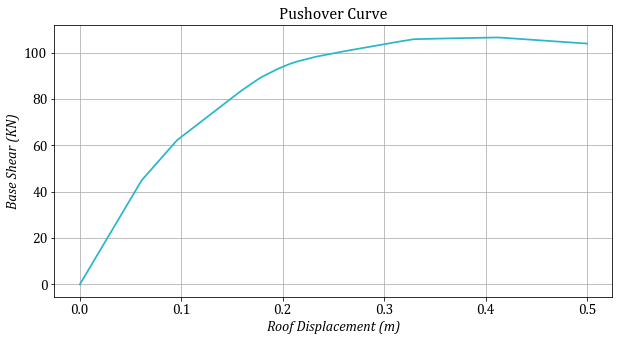

In [9]:
pover_x_react = np.loadtxt('FGU_2SSMRF_files/Pushover_Horizontal_Reactions.out')
pover_story_disp = np.loadtxt('FGU_2SSMRF_files/Pushover_Story_Displacement.out')
plt.figure(figsize=(10,5))
plt.plot(pover_story_disp[:,2],
         -(pover_x_react[:,1]+pover_x_react[:,2]), color = '#2ab7ca', linewidth=1.75)
plt.ylabel('Base Shear (KN)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Roof Displacement (m)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Pushover Curve',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14)
plt.xticks(fontname = 'Cambria', fontsize = 14);

#### Time History Analysis

##### Ground Motion histroy

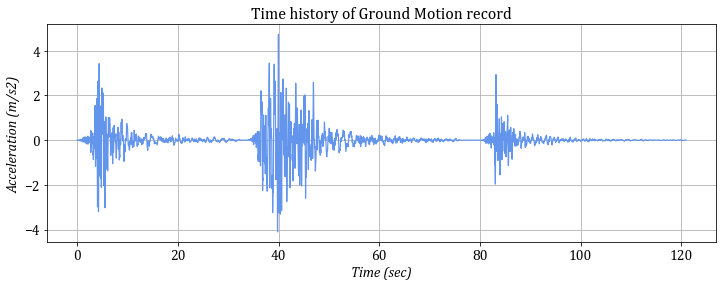

In [10]:
G_M =np.loadtxt('FGU_2SSMRF_files/acc_1.txt')
times = np.arange(0,0.02*len(G_M),0.02)
plt.figure(figsize=(12,4))
plt.plot(times,G_M, color = '#6495ED', linewidth=1.2)
plt.ylabel('Acceleration (m/s2)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Time history of Ground Motion record',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14);
plt.xticks(fontname = 'Cambria', fontsize = 14);

##### Time history of story displacement

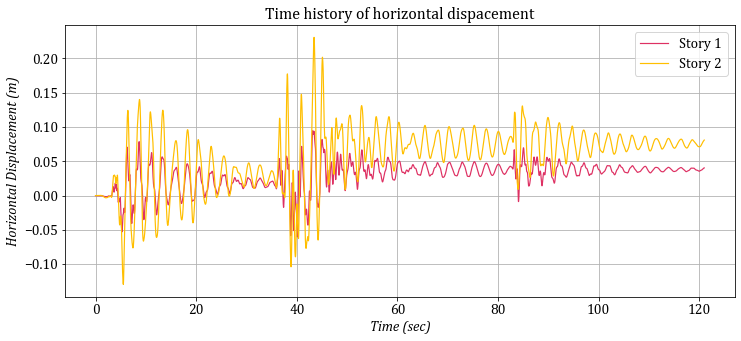

In [11]:
story_disp_th = np.loadtxt('FGU_2SSMRF_files/TimeHistory_Story_Displacement.1.1.out')
plt.figure(figsize=(12,5))
plt.plot(story_disp_th[:,0], story_disp_th[:,1], color = '#DE3163', linewidth=1.2)
plt.plot(story_disp_th[:,0], story_disp_th[:,2], color = '#FFBF00', linewidth=1.2)
plt.ylabel('Horizontal Displacement (m)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.xlabel('Time (sec)', {'fontname':'Cambria', 'fontstyle':'italic','size':14})
plt.grid(which='both')
plt.title('Time history of horizontal dispacement',{'fontname':'Cambria', 'fontstyle':'normal','size':16})
plt.yticks(fontname = 'Cambria', fontsize = 14);
plt.xticks(fontname = 'Cambria', fontsize = 14);
plt.legend(['Story 1', 'Story 2'],prop={'family':'Cambria','size':14});

### References

- <blockquote>Fernando Gutiérrez Urzúa's YouTube channel (https://www.youtube.com/user/lfgurzua) </blockquote>
- <blockquote>OpenseesPy Documentation (https://openseespydoc.readthedocs.io/en/latest/) </blockquote>
